## `modtox.Hypertuner`

In [1]:
import pandas as pd
import os

from modtox.modtox.ML.dataset import DataSet
target = "3ai8"
csv = os.path.join(os.path.abspath(""), "data", target,"mordred_topo_morgan.csv")
df = pd.read_csv(csv, index_col=0)
import warnings
warnings.filterwarnings('ignore')  # Ignore pandas warnings in output (copy/slice)

ds = DataSet(df)
dfs = ds.transform(outliers_threshold=0, resampling_method="oversampling", scaling_method="standarize")

In [2]:
import pickle5
with open(f"data/{target}/fitted_RFECV_step10.pickle", "rb") as f:
    fitted_sel = pickle5.load(f)
X_train_red = fitted_sel.transform(dfs["X_train"])
X_test_red = fitted_sel.transform(dfs["X_test"])

## Ref score ("none")

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef

y_test, y_train = dfs["y_test"], dfs["y_train"]

clf = VotingClassifier(estimators=[
    ("knn", KNeighborsClassifier()),
    ("lr", LogisticRegression()),
    ("svc", SVC()),
    ("tree", DecisionTreeClassifier()),
    ("nb", BernoulliNB())
])

fitted_clf = clf.fit(X_train_red, y_train)

y_pred_train = fitted_clf.predict(X_train_red)
ref_acc_train = accuracy_score(y_train, y_pred_train)
ref_matt_train = matthews_corrcoef(y_train, y_pred_train)

y_pred_test = fitted_clf.predict(X_test_red)
ref_acc_test = accuracy_score(y_test, y_pred_test)
ref_matt_test = matthews_corrcoef(y_test, y_pred_test)

ref_scores = [ref_acc_train, ref_acc_test, ref_matt_train, ref_matt_test]

## GridHalvingSearch
### Accuracy

In [4]:
from modtox.modtox.ML.tuning import GridHalvingSearch
from sklearn.metrics import accuracy_score

In [5]:
tuner = GridHalvingSearch(X_train_red, dfs["y_train"], scoring=accuracy_score)
fitted_clf,  grid_acc_train = tuner.search()

In [6]:
y_pred = fitted_clf.predict(X_test_red)
grid_acc_test = accuracy_score(dfs["y_test"], y_pred)

### Matthews

In [7]:
from sklearn.metrics import matthews_corrcoef

In [8]:
tuner = GridHalvingSearch(X_train_red, dfs["y_train"], scoring=matthews_corrcoef)
fitted_clf,  grid_matt_train = tuner.search()

In [9]:
y_pred = fitted_clf.predict(X_test_red)
grid_matt_test = matthews_corrcoef(dfs["y_test"], y_pred)

## RandomHalvingSearch
### Accuracy

In [10]:
from modtox.modtox.ML.tuning import RandomHalvingSearch
tuner = RandomHalvingSearch(X_train_red, dfs["y_train"], scoring=accuracy_score)
fitted_clf, train_scores = tuner.search()
rand_acc_train = train_scores["VotingClassifier"]
y_pred = fitted_clf.predict(X_test_red)
rand_acc_test = accuracy_score(dfs["y_test"], y_pred)

### Matthews

In [11]:
tuner = RandomHalvingSearch(X_train_red, dfs["y_train"], scoring=matthews_corrcoef)
fitted_clf, train_scores = tuner.search()
rand_matt_train = train_scores["VotingClassifier"]
y_pred = fitted_clf.predict(X_test_red)
rand_matt_test = accuracy_score(dfs["y_test"], y_pred)

## Plotting

In [12]:
grid_scores = [
    grid_acc_train["VotingClassifier"],
    grid_acc_test,
    grid_matt_train["VotingClassifier"],
    grid_matt_test,
]

rand_scores = [
    rand_acc_train,
    rand_acc_test,
    rand_matt_train,
    rand_matt_test,
]

df = pd.DataFrame([ref_scores, grid_scores, rand_scores], columns=["train_acc", "test_acc", "train_matt", "test_matt"])
df["halving"] = ["none", "grid", "random"]
df.to_csv(f"data/{target}/tuning.csv")
df

,train_acc,test_acc,train_matt,test_matt,halving
0,0.976584,0.841727,0.953461,0.642418,none
1,0.877410,0.726619,0.877410,0.488635,grid
2,0.994490,0.784173,0.994490,0.784173,random


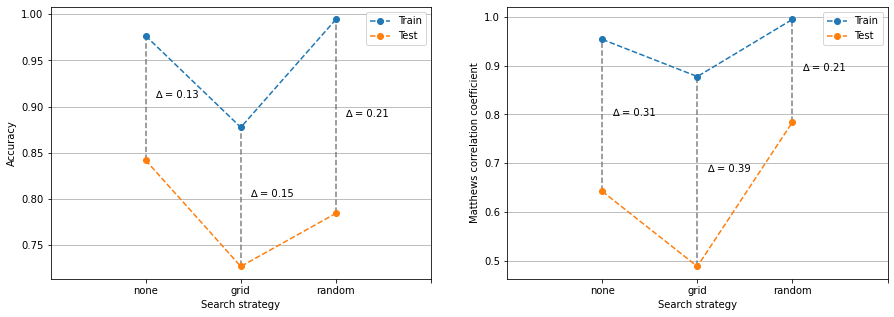

In [13]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sc = df[["halving", "train_acc", "test_acc"]]
sc.plot(
    x="halving", 
    marker="o", 
    linestyle="--", 
    xlim=(-1, 3), 
    xticks=[0, 1, 2, 3, 4], 
    xlabel="Search strategy", 
    ylabel="Accuracy",
    ax=axs[0]
)
axs[0].legend(["Train", "Test"])
axs[0].grid(axis="y")
for i, met in enumerate(["none", "grid", "random"]):
    test = sc[sc["halving"] == met]["test_acc"]
    train = sc[sc["halving"] == met]["train_acc"]
    diff = float(train-test)
    axs[0].vlines(x=i, ymin=test, ymax=train, color="gray", linestyle="--")
    axs[0].text(x=i+0.1, y=test + diff/2, s=f"∆ = {diff:.2f}")

sc = df[["halving", "train_matt", "test_matt"]]
sc.plot(
    x="halving", 
    marker="o", 
    linestyle="--", 
    xlim=(-1, 3), 
    xticks=[0, 1, 2, 3, 4], 
    xlabel="Search strategy", 
    ylabel="Matthews correlation coefficient",
    ax=axs[1]
)
axs[1].legend(["Train", "Test"])
axs[1].grid(axis="y")
for i, met in enumerate(["none", "grid", "random"]):
    test = sc[sc["halving"] == met]["test_matt"]
    train = sc[sc["halving"] == met]["train_matt"]
    diff = float(train-test)
    axs[1].vlines(x=i, ymin=test, ymax=train, color="gray", linestyle="--")
    axs[1].text(x=i+0.1, y=test + diff/2, s=f"∆ = {diff:.2f}")
plt.savefig(f"data/{target}/tuning.png")